In [1]:
%pylab inline

import os
import itertools as it
from scipy.ndimage.filters import gaussian_filter

from tools.stats import err, binner

from styles.paper import *
from styles.colors import *
from styles.labels import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def residual_table(residuals, masks, residual_labels, mask_labels, keywords):

    for i in xrange(len(keywords)):
        bias_a, pres_a = [], []
        bias_b, pres_b = [], []
        bias_c, pres_c = [], []
        for mask in masks:
            bias_a.append(median(residuals[0][keywords[i]][mask]))
            pres_a.append(diff(percentile(residuals[0][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_b.append(median(residuals[1][keywords[i]][mask]))
            pres_b.append(diff(percentile(residuals[1][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_c.append(median(residuals[2][keywords[i]][mask]))
            pres_c.append(diff(percentile(residuals[2][keywords[i]][mask], [16,84]))[0]*0.5)

        for j in xrange(len(masks)):
            if j==0:
                print r"\multirow{3}{*}{%s}   &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (residual_labels[i], mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
            else:
                print r"                          &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
        print r"\hline"

def plot_residual_hist(residuals, labels, keywords, res_lbs, limits=((-0.2, 0.2), (1.3, 3.0)), colors=(samples["light"], samples["dark"]), nbins=15):
    xlm, ylm = limits

    fig, axs = subplots(3, len(keywords), figsize=(7,4), sharex=True, sharey=True)

    axs[0, 0].set_xlim(xlm)
    axs[0, 0].set_xticks([-0.1, 0, 0.1])
    axs[1, 0].set_ylabel(r"\bf $u-r$")

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        x, y, e = binner(lcolor, residuals[i][keywords[j]], nbins, ylm, "median")

        axs[i, j].plot(gaussian_filter(y,1.5), x, "-", color=colors[1], lw=1.5)
        axs[i, j].fill_betweenx(x, gaussian_filter(y-e[0],1.5), gaussian_filter(y+e[1],1.5), facecolor=colors[0], lw=0)

        axs[i, j].axvline(ls=":", color="k", lw=0.7)
        axs[i, j].axhline(2.22, ls=":", color="k", lw=0.7)

        if i==2: axs[i, j].set_xlabel(res_lbs[keywords[j]])
        if j==0:
            axs[i, j].text(0.05, 0.95, labels[i], fontsize="small", ha="left", va="top", transform=axs[i, j].transAxes)

    axs[1, 0].set_ylim(x[0], x[-1])

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
    return fig

In [3]:
#load model grid
class DynbasOutput():
    def __init__(self, filename):
        self.filename = filename
        self.file = open(filename, "r")
        
        self.file.readline()
        self.file.readline()

        self.age_grid = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.met_grid = array(map(eval, self.file.readline()[:-1].split("=")[1].split()[:-1]))
        self.ext_grid = array(map(eval, self.file.readline()[:-1].split("=")[1].split()[:-1]))
        
        self.file.readline()
        self.file.readline()
        self.file.readline()
        self.file.readline()
        
        self.age_1d = array([eval(self.file.readline()[:-1].split("=")[1])])
        self.age_2d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.age_3d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        
        self.met_1d = array([eval(self.file.readline()[:-1].split("=")[1])])
        self.met_2d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.met_3d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        
        self.mas_1d = array([eval(self.file.readline()[:-1].split("=")[1])])
        self.mas_2d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.mas_3d = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        
        self.file.readline()
        self.file.readline()
        self.file.readline()
        self.file.readline()
        
        self.mass = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.mwla = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.lwla = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.mwlz = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.lwlz = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.extv = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
        self.chis = array(map(eval, self.file.readline()[:-1].split("=")[1].split()))
    def get_grid(self):
        return self.age_grid, self.met_grid, self.ext_grid
    def get_properties(self):
        return self.mass, self.mwla, self.lwla, self.mwlz, self.lwlz, self.extv
    def get_best_properties(self):
        i = argmin(self.chis)
        return self.mass[i], self.mwla[i], self.lwla[i], self.mwlz[i], self.lwlz[i], self.extv[i]
    def get_model(self):
        return (self.mas_1d, self.mas_2d, self.mas_3d), (self.age_1d, self.age_2d, self.age_3d), (self.met_1d, self.met_2d, self.met_3d), self.extv
    def get_best_model(self):
        i = argmin(self.chis)
        return (self.mas_1d, self.mas_2d, self.mas_3d)[i], (self.age_1d, self.age_2d, self.age_3d)[i], (self.met_1d, self.met_2d, self.met_3d)[i], array([self.extv[i]])
    def compute_expected_error(self):
        mas, age, met, ext = self.get_best_model()
        
        model_ingredients = age, met, ext
        model_grids = self.get_grid()
                
        errors = []
        for j in xrange(len(model_grids)):
            error = []
            for k in xrange(len(model_ingredients[j])):
                i = argmin(abs(model_ingredients[j][k]-model_grids[j]))
                
                if i==0:
                    error.append(model_grids[j][i+1]-model_grids[j][i])
                elif i==model_grids[j].size-1:
                    error.append(model_grids[j][i]-model_grids[j][i-1])
                else:
                    error.append((model_grids[j][i+1]-model_grids[j][i-1])*0.5)

            errors.append(error)
            
        self.age_error, self.met_error, self.ext_error = array(errors[0]), array(errors[1]), array(errors[2])
        return self.age_error, self.met_error, self.ext_error

In [4]:
flist = sorted([os.path.join(root, file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/jpas/") for file in files if file.startswith("dynbasfit_")])

errors = []
for file in flist:
    test = DynbasOutput(file)
    error = test.compute_expected_error()[0]
    if error.size==3:
        errors.append(sqrt(sum((test.mas_3d/test.mas_3d.sum()*error/test.age_3d)**2)))
    elif error.size==2:
        errors.append(sqrt(sum((test.mas_2d/test.mas_2d.sum()*error/test.age_2d)**2)))
    else:
        errors.append(sqrt(sum((test.mas_1d/test.mas_1d.sum()*error/test.age_1d)**2)))

errors = array(errors)

In [5]:
#load outputs from S/N tests

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws]

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kws = [field.rstrip("_mod") for field in fields]

pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

#high-S/N test (S/N=999.9 for all spectral resolutions)
# sdss_hsn = genfromtxt("../inputs/proof_biasless/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws]
# jpas_hsn = genfromtxt("../inputs/proof_biasless/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws]
# spec_hsn = genfromtxt("../inputs/proof_biasless/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws]

In [6]:
sdss_list = sorted([os.path.join(root,file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/sdss") for file in files if file.startswith("dynbasfit_")])
jpas_list = sorted([os.path.join(root,file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/jpas") for file in files if file.startswith("dynbasfit_")])
spec_list = sorted([os.path.join(root,file) for root, subs, files in os.walk("../inputs/proof_biasless/outs/spec") for file in files if file.startswith("dynbasfit_")])

sdss_1d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
sdss_2d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
sdss_3d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
jpas_1d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
jpas_2d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
jpas_3d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
spec_1d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
spec_2d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
spec_3d = dict(
    M_mod = [],
    log_t_M_mod = [],
    log_t_L_mod = [],
    log_Z_M_mod = [],
    log_Z_L_mod = [],
    Av_mod = []
)
kws_mod = "M_mod log_t_M_mod log_t_L_mod log_Z_M_mod log_Z_L_mod Av_mod".split()
for i in xrange(len(sdss_list)):
    sdss = DynbasOutput(sdss_list[i])
    jpas = DynbasOutput(jpas_list[i])
    spec = DynbasOutput(spec_list[i])
    
    sdss_props = sdss.get_properties()
    jpas_props = jpas.get_properties()
    spec_props = spec.get_properties()
    for j in xrange(len(kws_mod)):
        sdss_1d[kws_mod[j]].append(sdss_props[j][0])
        sdss_2d[kws_mod[j]].append(sdss_props[j][1])
        sdss_3d[kws_mod[j]].append(sdss_props[j][2])
        
        jpas_1d[kws_mod[j]].append(jpas_props[j][0])
        jpas_2d[kws_mod[j]].append(jpas_props[j][1])
        jpas_3d[kws_mod[j]].append(jpas_props[j][2])
        
        spec_1d[kws_mod[j]].append(spec_props[j][0])
        spec_2d[kws_mod[j]].append(spec_props[j][1])
        spec_3d[kws_mod[j]].append(spec_props[j][2])

for j in xrange(len(kws_mod)):
    if j==0:
        sdss_1d[kws_mod[j]] = log10(array(sdss_1d[kws_mod[j]]))[mask_ws]
        sdss_2d[kws_mod[j]] = log10(array(sdss_2d[kws_mod[j]]))[mask_ws]
        sdss_3d[kws_mod[j]] = log10(array(sdss_3d[kws_mod[j]]))[mask_ws]

        jpas_1d[kws_mod[j]] = log10(array(jpas_1d[kws_mod[j]]))[mask_ws]
        jpas_2d[kws_mod[j]] = log10(array(jpas_2d[kws_mod[j]]))[mask_ws]
        jpas_3d[kws_mod[j]] = log10(array(jpas_3d[kws_mod[j]]))[mask_ws]

        spec_1d[kws_mod[j]] = log10(array(spec_1d[kws_mod[j]]))[mask_ws]
        spec_2d[kws_mod[j]] = log10(array(spec_2d[kws_mod[j]]))[mask_ws]
        spec_3d[kws_mod[j]] = log10(array(spec_3d[kws_mod[j]]))[mask_ws]
    else:
        sdss_1d[kws_mod[j]] = array(sdss_1d[kws_mod[j]])[mask_ws]
        sdss_2d[kws_mod[j]] = array(sdss_2d[kws_mod[j]])[mask_ws]
        sdss_3d[kws_mod[j]] = array(sdss_3d[kws_mod[j]])[mask_ws]

        jpas_1d[kws_mod[j]] = array(jpas_1d[kws_mod[j]])[mask_ws]
        jpas_2d[kws_mod[j]] = array(jpas_2d[kws_mod[j]])[mask_ws]
        jpas_3d[kws_mod[j]] = array(jpas_3d[kws_mod[j]])[mask_ws]

        spec_1d[kws_mod[j]] = array(spec_1d[kws_mod[j]])[mask_ws]
        spec_2d[kws_mod[j]] = array(spec_2d[kws_mod[j]])[mask_ws]
        spec_3d[kws_mod[j]] = array(spec_3d[kws_mod[j]])[mask_ws]


In [7]:
ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])

#compute residuals and discrepancies
sdss_res_1d = dict(
    M=err(ssag_tta["M_lib"], sdss_1d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_1d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_1d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_1d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_1d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_1d["Av_mod"], False)
)
jpas_res_1d = dict(
    M=err(ssag_tta["M_lib"], jpas_1d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_1d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_1d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_1d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_1d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_1d["Av_mod"], False)
)
spec_res_1d = dict(
    M=err(ssag_tta["M_lib"], spec_1d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_1d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_1d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_1d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_1d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_1d["Av_mod"], False)
)

sdss_res_2d = dict(
    M=err(ssag_tta["M_lib"], sdss_2d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_2d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_2d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_2d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_2d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_2d["Av_mod"], False)
)
jpas_res_2d = dict(
    M=err(ssag_tta["M_lib"], jpas_2d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_2d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_2d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_2d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_2d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_2d["Av_mod"], False)
)
spec_res_2d = dict(
    M=err(ssag_tta["M_lib"], spec_2d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_2d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_2d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_2d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_2d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_2d["Av_mod"], False)
)

sdss_res_3d = dict(
    M=err(ssag_tta["M_lib"], sdss_3d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_3d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_3d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_3d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_3d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_3d["Av_mod"], False)
)
jpas_res_3d = dict(
    M=err(ssag_tta["M_lib"], jpas_3d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_3d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_3d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_3d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_3d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_3d["Av_mod"], False)
)
spec_res_3d = dict(
    M=err(ssag_tta["M_lib"], spec_3d["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_3d["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_3d["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_3d["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_3d["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_3d["Av_mod"], False)
)

In [8]:
residual_table([spec_res_1d,jpas_res_1d,sdss_res_1d], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), ["SFGs","PaGs","All Gals."], kws)

\multirow{3}{*}{\dlogm}   &      SFGs &    -0.123 &     0.150 & &    -0.149 &     0.166 & &    -0.280 &     0.377\\
                          &      PaGs &    -0.049 &     0.147 & &    -0.051 &     0.137 & &    -0.033 &     0.158\\
                          & All Gals. &    -0.110 &     0.160 & &    -0.126 &     0.166 & &    -0.203 &     0.253\\
\hline
\multirow{3}{*}{\dmwla}   &      SFGs &    -0.346 &     0.252 & &    -0.394 &     0.323 & &    -0.577 &     0.673\\
                          &      PaGs &    -0.119 &     0.185 & &    -0.108 &     0.156 & &    -0.030 &     0.270\\
                          & All Gals. &    -0.266 &     0.283 & &    -0.249 &     0.312 & &    -0.310 &     0.595\\
\hline
\multirow{3}{*}{\dlwla}   &      SFGs &     0.003 &     0.161 & &    -0.050 &     0.233 & &    -0.156 &     0.523\\
                          &      PaGs &    -0.028 &     0.135 & &     0.002 &     0.134 & &     0.052 &     0.204\\
                          & All Gals. &    -0.006 &     0.

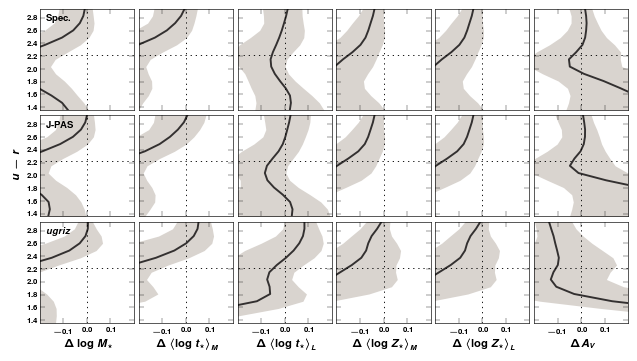

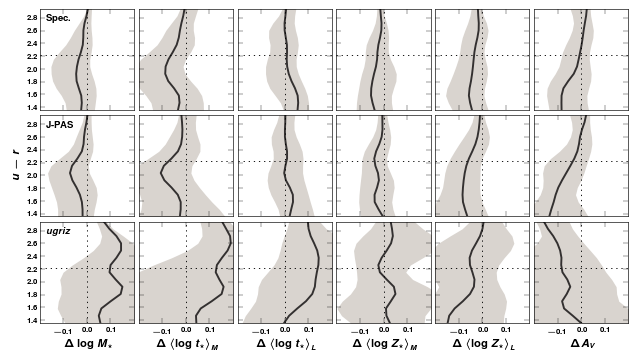

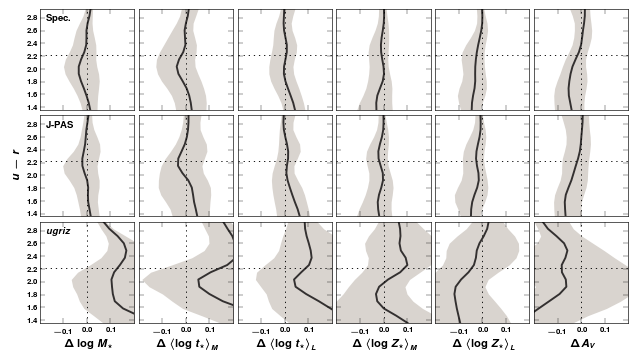

In [9]:
fig = plot_residual_hist((spec_res_1d, jpas_res_1d, sdss_res_1d), labels=(r"\bf Spec.", r"\bf J-PAS", r"\bf $ugriz$"), keywords=kws, res_lbs=Delta)
fig = plot_residual_hist((spec_res_2d, jpas_res_2d, sdss_res_2d), labels=(r"\bf Spec.", r"\bf J-PAS", r"\bf $ugriz$"), keywords=kws, res_lbs=Delta)
fig = plot_residual_hist((spec_res_3d, jpas_res_3d, sdss_res_3d), labels=(r"\bf Spec.", r"\bf J-PAS", r"\bf $ugriz$"), keywords=kws, res_lbs=Delta)
#fig.savefig(os.path.expandvars("$HOME/Documents/Publications/mejia+2016/noiseless_residuals.pdf"))

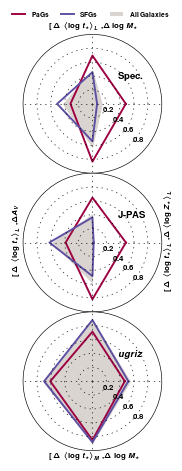

In [10]:
degeneracies = ("log_t_L", "log_Z_L"), ("log_t_L", "M"), ("log_t_L", "Av"), ("log_t_M", "M")
thetas = 0.0, pi/2, pi, 1.5*pi
labels = r"\bf Spec.", r"\bf J-PAS", r"\bf $ugriz$"
colors = cm.Spectral(linspace(0,1,2))

spec_deg_pa, jpas_deg_pa, sdss_deg_pa = [], [], []
spec_deg_sf, jpas_deg_sf, sdss_deg_sf = [], [], []
spec_deg_al, jpas_deg_al, sdss_deg_al = [], [], []
for degeneracy in degeneracies:
    x, y = degeneracy

    spec_deg_pa.append(abs(corrcoef(spec_res_1d[x][pags], spec_res_1d[y][pags])[0,1]))
    jpas_deg_pa.append(abs(corrcoef(jpas_res_1d[x][pags], jpas_res_1d[y][pags])[0,1]))
    sdss_deg_pa.append(abs(corrcoef(sdss_res_1d[x][pags], sdss_res_1d[y][pags])[0,1]))
    
    spec_deg_sf.append(abs(corrcoef(spec_res_1d[x][sfgs], spec_res_1d[y][sfgs])[0,1]))
    jpas_deg_sf.append(abs(corrcoef(jpas_res_1d[x][sfgs], jpas_res_1d[y][sfgs])[0,1]))
    sdss_deg_sf.append(abs(corrcoef(sdss_res_1d[x][sfgs], sdss_res_1d[y][sfgs])[0,1]))
    
    spec_deg_al.append(abs(corrcoef(spec_res_1d[x], spec_res_1d[y])[0,1]))
    jpas_deg_al.append(abs(corrcoef(jpas_res_1d[x], jpas_res_1d[y])[0,1]))
    sdss_deg_al.append(abs(corrcoef(sdss_res_1d[x], sdss_res_1d[y])[0,1]))

degs_pa = [spec_deg_pa, jpas_deg_pa, sdss_deg_pa]
degs_sf = [spec_deg_sf, jpas_deg_sf, sdss_deg_sf]
degs_al = [spec_deg_al, jpas_deg_al, sdss_deg_al]

fig = figure(figsize=(3.3, 5))

template = r"$\left[{},{}\right]$"
deg_kws = ("log_t_L","log_Z_L"), ("log_t_L", "M"), ("log_t_L","Av"), ("log_t_M", "M")
for j, lb in enumerate(labels):
    ax = fig.add_subplot(3, 1, j+1, projection="polar")
    ax.set_rlim(0, 1)
    ax.text(pi/4, 0.5, labels[j], fontsize="small")
    
    ax.set_rgrids(linspace(0.2,0.8,4), angle=-45)

    if j==0:
        deg_lbs = [r"" if i!=1 else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    if j==1:
        deg_lbs = [r"" if i in [1,3] else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    if j==2:
        deg_lbs = [r"" if i!=3 else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    
    for text in t[::2]: text.set_rotation(90)
    
    ax.fill_between(thetas+thetas[0:1], degs_al[j]+degs_al[j][0:1], color=samples["light"], lw=0, label=r"\bf All Galaxies")
    ax.plot(thetas+thetas[0:1], degs_pa[j]+degs_pa[j][0:1], "-", lw=1.5, color=colors[0], label=r"\bf PaGs")
    ax.plot(thetas+thetas[0:1], degs_sf[j]+degs_sf[j][0:1], "-", lw=1.5, color=colors[1], label=r"\bf SFGs")

ax.legend(loc=(-0.1,3.1), ncol=3)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

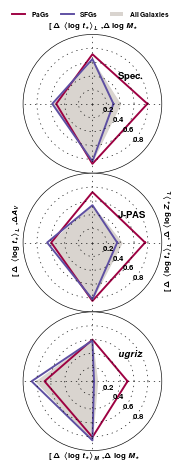

In [11]:
degeneracies = ("log_t_L", "log_Z_L"), ("log_t_L", "M"), ("log_t_L", "Av"), ("log_t_M", "M")
thetas = 0.0, pi/2, pi, 1.5*pi
labels = r"\bf Spec.", r"\bf J-PAS", r"\bf $ugriz$"
colors = cm.Spectral(linspace(0,1,2))

spec_deg_pa, jpas_deg_pa, sdss_deg_pa = [], [], []
spec_deg_sf, jpas_deg_sf, sdss_deg_sf = [], [], []
spec_deg_al, jpas_deg_al, sdss_deg_al = [], [], []
for degeneracy in degeneracies:
    x, y = degeneracy

    spec_deg_pa.append(abs(corrcoef(spec_res_2d[x][pags], spec_res_2d[y][pags])[0,1]))
    jpas_deg_pa.append(abs(corrcoef(jpas_res_2d[x][pags], jpas_res_2d[y][pags])[0,1]))
    sdss_deg_pa.append(abs(corrcoef(sdss_res_2d[x][pags], sdss_res_2d[y][pags])[0,1]))
    
    spec_deg_sf.append(abs(corrcoef(spec_res_2d[x][sfgs], spec_res_2d[y][sfgs])[0,1]))
    jpas_deg_sf.append(abs(corrcoef(jpas_res_2d[x][sfgs], jpas_res_2d[y][sfgs])[0,1]))
    sdss_deg_sf.append(abs(corrcoef(sdss_res_2d[x][sfgs], sdss_res_2d[y][sfgs])[0,1]))
    
    spec_deg_al.append(abs(corrcoef(spec_res_2d[x], spec_res_2d[y])[0,1]))
    jpas_deg_al.append(abs(corrcoef(jpas_res_2d[x], jpas_res_2d[y])[0,1]))
    sdss_deg_al.append(abs(corrcoef(sdss_res_2d[x], sdss_res_2d[y])[0,1]))

degs_pa = [spec_deg_pa, jpas_deg_pa, sdss_deg_pa]
degs_sf = [spec_deg_sf, jpas_deg_sf, sdss_deg_sf]
degs_al = [spec_deg_al, jpas_deg_al, sdss_deg_al]

fig = figure(figsize=(3.3, 5))

template = r"$\left[{},{}\right]$"
deg_kws = ("log_t_L","log_Z_L"), ("log_t_L", "M"), ("log_t_L","Av"), ("log_t_M", "M")
for j, lb in enumerate(labels):
    ax = fig.add_subplot(3, 1, j+1, projection="polar")
    ax.set_rlim(0, 1)
    ax.text(pi/4, 0.5, labels[j], fontsize="small")
    
    ax.set_rgrids(linspace(0.2,0.8,4), angle=-45)

    if j==0:
        deg_lbs = [r"" if i!=1 else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    if j==1:
        deg_lbs = [r"" if i in [1,3] else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    if j==2:
        deg_lbs = [r"" if i!=3 else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    
    for text in t[::2]: text.set_rotation(90)
    
    ax.fill_between(thetas+thetas[0:1], degs_al[j]+degs_al[j][0:1], color=samples["light"], lw=0, label=r"\bf All Galaxies")
    ax.plot(thetas+thetas[0:1], degs_pa[j]+degs_pa[j][0:1], "-", lw=1.5, color=colors[0], label=r"\bf PaGs")
    ax.plot(thetas+thetas[0:1], degs_sf[j]+degs_sf[j][0:1], "-", lw=1.5, color=colors[1], label=r"\bf SFGs")

ax.legend(loc=(-0.1,3.1), ncol=3)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

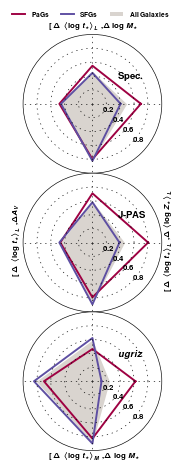

In [12]:
degeneracies = ("log_t_L", "log_Z_L"), ("log_t_L", "M"), ("log_t_L", "Av"), ("log_t_M", "M")
thetas = 0.0, pi/2, pi, 1.5*pi
labels = r"\bf Spec.", r"\bf J-PAS", r"\bf $ugriz$"
colors = cm.Spectral(linspace(0,1,2))

spec_deg_pa, jpas_deg_pa, sdss_deg_pa = [], [], []
spec_deg_sf, jpas_deg_sf, sdss_deg_sf = [], [], []
spec_deg_al, jpas_deg_al, sdss_deg_al = [], [], []
for degeneracy in degeneracies:
    x, y = degeneracy

    spec_deg_pa.append(abs(corrcoef(spec_res_3d[x][pags], spec_res_3d[y][pags])[0,1]))
    jpas_deg_pa.append(abs(corrcoef(jpas_res_3d[x][pags], jpas_res_3d[y][pags])[0,1]))
    sdss_deg_pa.append(abs(corrcoef(sdss_res_3d[x][pags], sdss_res_3d[y][pags])[0,1]))
    
    spec_deg_sf.append(abs(corrcoef(spec_res_3d[x][sfgs], spec_res_3d[y][sfgs])[0,1]))
    jpas_deg_sf.append(abs(corrcoef(jpas_res_3d[x][sfgs], jpas_res_3d[y][sfgs])[0,1]))
    sdss_deg_sf.append(abs(corrcoef(sdss_res_3d[x][sfgs], sdss_res_3d[y][sfgs])[0,1]))
    
    spec_deg_al.append(abs(corrcoef(spec_res_3d[x], spec_res_3d[y])[0,1]))
    jpas_deg_al.append(abs(corrcoef(jpas_res_3d[x], jpas_res_3d[y])[0,1]))
    sdss_deg_al.append(abs(corrcoef(sdss_res_3d[x], sdss_res_3d[y])[0,1]))

degs_pa = [spec_deg_pa, jpas_deg_pa, sdss_deg_pa]
degs_sf = [spec_deg_sf, jpas_deg_sf, sdss_deg_sf]
degs_al = [spec_deg_al, jpas_deg_al, sdss_deg_al]

fig = figure(figsize=(3.3, 5))

template = r"$\left[{},{}\right]$"
deg_kws = ("log_t_L","log_Z_L"), ("log_t_L", "M"), ("log_t_L","Av"), ("log_t_M", "M")
for j, lb in enumerate(labels):
    ax = fig.add_subplot(3, 1, j+1, projection="polar")
    ax.set_rlim(0, 1)
    ax.text(pi/4, 0.5, labels[j], fontsize="small")
    
    ax.set_rgrids(linspace(0.2,0.8,4), angle=-45)

    if j==0:
        deg_lbs = [r"" if i!=1 else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    if j==1:
        deg_lbs = [r"" if i in [1,3] else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    if j==2:
        deg_lbs = [r"" if i!=3 else template.format(Delta[x].strip("$"),Delta[y].strip("$")) for i,(x,y) in enumerate(deg_kws)]
        l, t = ax.set_thetagrids(degrees(thetas), labels=deg_lbs)
    
    for text in t[::2]: text.set_rotation(90)
    
    ax.fill_between(thetas+thetas[0:1], degs_al[j]+degs_al[j][0:1], color=samples["light"], lw=0, label=r"\bf All Galaxies")
    ax.plot(thetas+thetas[0:1], degs_pa[j]+degs_pa[j][0:1], "-", lw=1.5, color=colors[0], label=r"\bf PaGs")
    ax.plot(thetas+thetas[0:1], degs_sf[j]+degs_sf[j][0:1], "-", lw=1.5, color=colors[1], label=r"\bf SFGs")

ax.legend(loc=(-0.1,3.1), ncol=3)
fig.tight_layout()
fig.subplots_adjust(hspace=0)